## Task 1: Project Objective
* The objective of this project is to predict which credit card transactions in the dataset are fraudulent using three classification algorithms and three synthetic balancing techniques. The three classifier algorithms we will train include:
  + Decision Tree, which uses a tree-like model of decisions to arrive at a classification prediction.
  + Naive Bayes, which uses Bayes' theorem to use probability to arrive at a classification prediction.
  + Linear Discriminant Analysis, which finds a linear combination of features that is then used to separate the classes and arrive at a classification prediction.

* Given that the objective is to evaluate the model performance of the three classifier algorithms and synthetic balancing techniques, we will not be thoroughly reviewing the model output, but rather will be focusing on the classification performance results.

* Lets start by loading the R library packages that will be used in this project, which are the caret, corrplot, and smotefamily packages.

In [1]:
#Load the packages used in the project
library(caret)
library(corrplot)
library(smotefamily)

Loading required package: lattice
Loading required package: ggplot2
Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
corrplot 0.92 loaded
Warning message:
“package ‘smotefamily’ was built under R version 3.6.3”

### Task 1.1: Import the dataset from Dropbox

Next, using the "read.csv" function, we will import the credit card fraud dataset and set the class to a factor. This dataset is a subset of the dataset from sourced from https://www.kaggle.com/mlg-ulb/creditcardfraud, which includes anonymized credit card transactions.

In [2]:
#A. Load the dataset
creditcardFraud <- read.csv("creditcardFraud.csv")

In [3]:
#B. Change class to factor the as.factor function encodes the vector as a factor or category
creditcardFraud$class<-as.factor(creditcardFraud$class)

## Task 2: Explore The Data

* Now that we have downloaded the data we can start the training of the models, but it is important that we first understand and explore our data as it helps us identify potential data quality issues and it provides us the needed context to develop an appropriate model.  

* In this project, we will briefly explore the data and perform a high-level exploratory data analysis (EDA) of the dataset

In [4]:
#A. Structure of the dataset
str(creditcardFraud)

'data.frame':	49692 obs. of  31 variables:
 $ Time  : int  406 472 4462 6986 7519 7526 7535 7543 7551 7610 ...
 $ V1    : num  -2.31 -3.04 -2.3 -4.4 1.23 ...
 $ V2    : num  1.95 -3.16 1.76 1.36 3.02 ...
 $ V3    : num  -1.61 1.09 -0.36 -2.59 -4.3 ...
 $ V4    : num  4 2.29 2.33 2.68 4.73 ...
 $ V5    : num  -0.522 1.36 -0.822 -1.128 3.624 ...
 $ V6    : num  -1.4265 -1.0648 -0.0758 -1.7065 -1.3577 ...
 $ V7    : num  -2.537 0.326 0.562 -3.496 1.713 ...
 $ V8    : num  1.3917 -0.0678 -0.3991 -0.2488 -0.4964 ...
 $ V9    : num  -2.77 -0.271 -0.238 -0.248 -1.283 ...
 $ V10   : num  -2.772 -0.839 -1.525 -4.802 -2.447 ...
 $ V11   : num  3.202 -0.415 2.033 4.896 2.101 ...
 $ V12   : num  -2.9 -0.503 -6.56 -10.913 -4.61 ...
 $ V13   : num  -0.5952 0.6765 0.0229 0.1844 1.4644 ...
 $ V14   : num  -4.29 -1.69 -1.47 -6.77 -6.08 ...
 $ V15   : num  0.38972 2.00063 -0.69883 -0.00733 -0.33924 ...
 $ V16   : num  -1.141 0.667 -2.282 -7.358 2.582 ...
 $ V17   : num  -2.83 0.6 -4.78 -12.6 6.74 ...
 $

In [5]:
#B. Missing data?
sum(is.na(creditcardFraud))

[1] 0

In [6]:
#C. Check the imbalance in the dataset
table(creditcardFraud$class)
prop.table(table(creditcardFraud$class))


   no   yes 
49200   492 


        no        yes 
0.99009901 0.00990099 

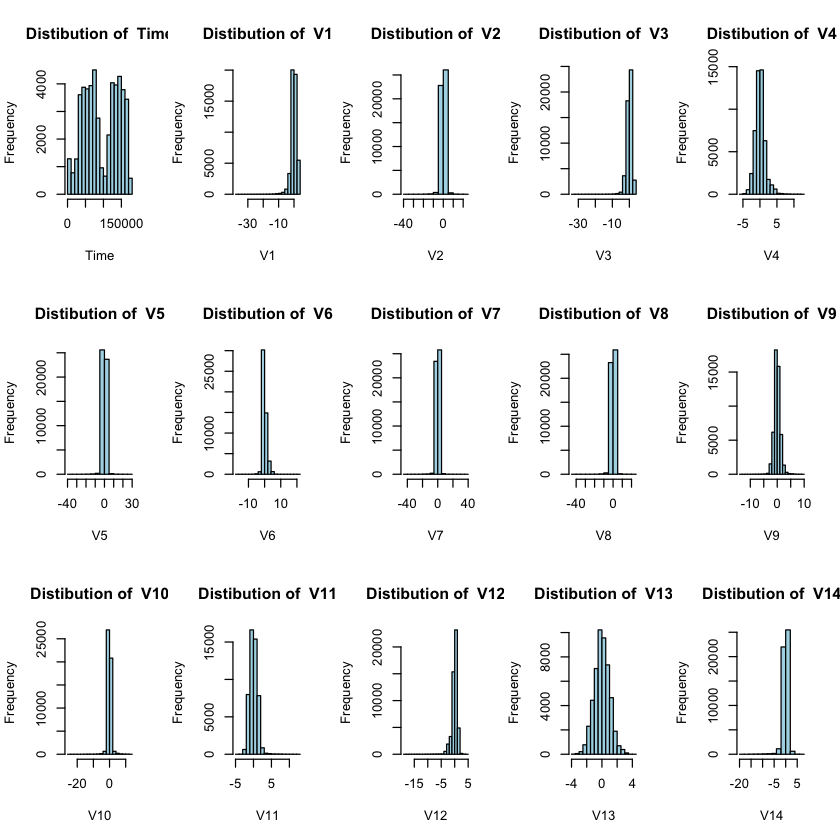

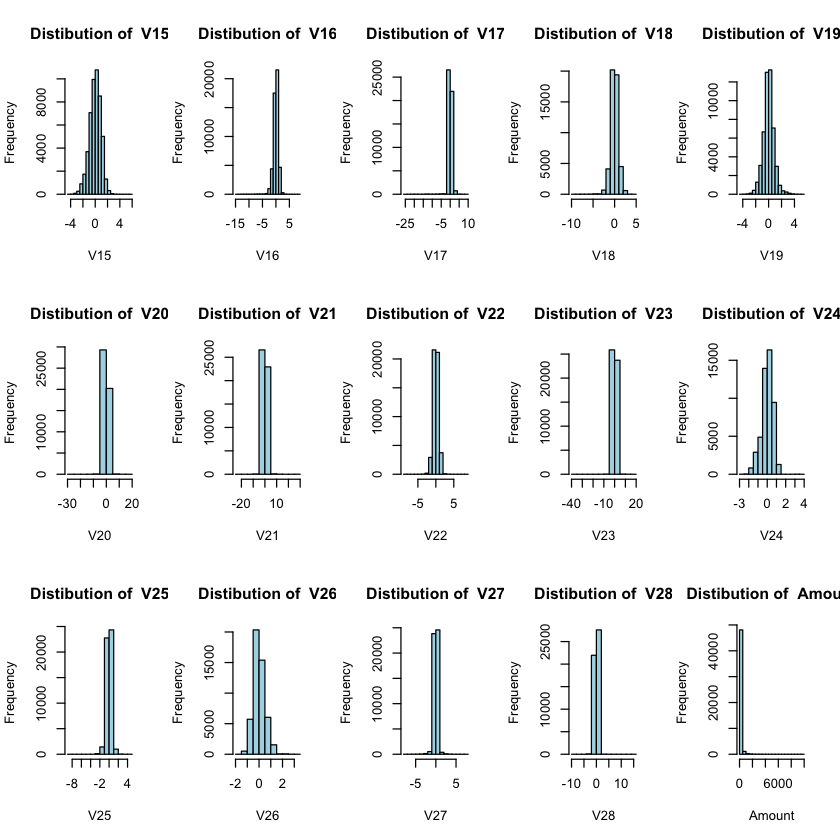

In [7]:
#D. Compile histograms for each variable
par(mfrow = c(3,5)) #Change setting to view 3x5 charts
i <- 1
for (i in 1:30) 
{hist((creditcardFraud[,i]), main = paste("Distibution of ", colnames(creditcardFraud[i])), xlab = colnames(creditcardFraud[i]), col = "light blue")
}

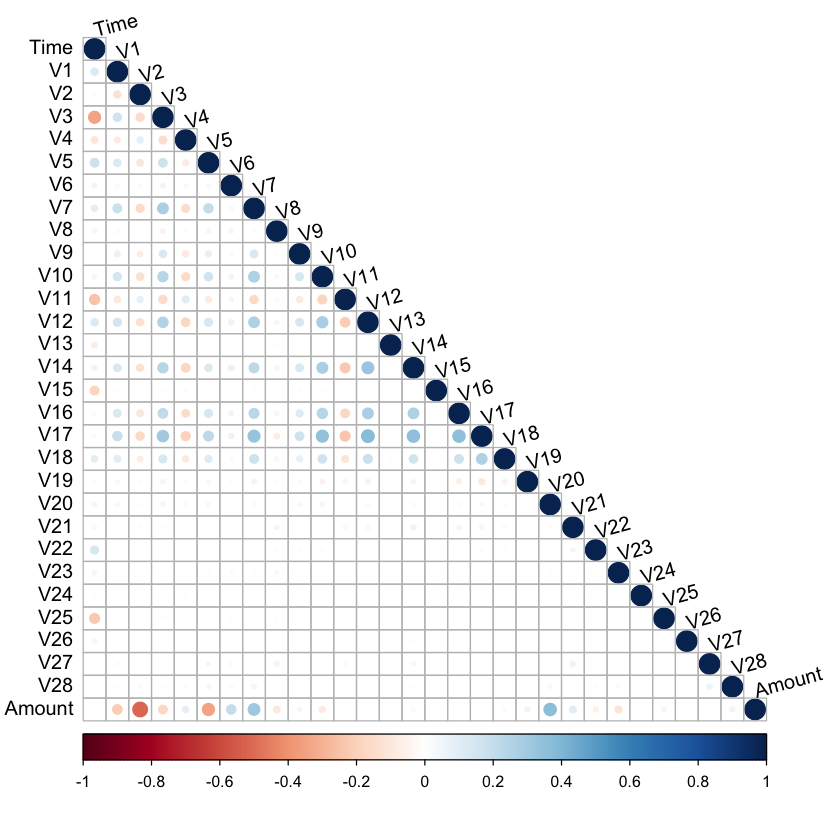

In [8]:
#E. Compute the correlations among the variables
r <- cor(creditcardFraud[,1:30])
corrplot(r, type = "lower", tl.col = 'black',  tl.srt = 15)

## Task 3: Split the Data into Training and Test Sets

It is important that when we evaluate the performance of a model, we do so on a dataset that the model has not previously seen. Therefore, we will split our dataset into a training dataset and a test dataset and to maintain the same level of imbalance as in the original dataset, we will use stratified sampling by "class."

* Training Dataset: This is the random subset of your data used to initially fit (or train) your model.

* Test Dataset: This dataset used to provide an unbiased evaluation of the model fit on the training dataset.

In [9]:
#A. Split data into training and testing dataset used for model building (training dataset) 
set.seed(1337)
train<-createDataPartition(creditcardFraud$class,
                           p = .70, #% of data going to training
                           times = 1,#of partitions to create
                           list = F) 

train.orig<-creditcardFraud[train,]
test<-creditcardFraud[-train,]

#B. Check the proportion of observations allocated to each group
dim(train.orig) / dim(creditcardFraud)

[1] 0.7000121 1.0000000

In [10]:
#C. Class balance for training dataset
prop.table(table(train.orig$class))


         no         yes 
0.990081932 0.009918068 

In [11]:
#D. Class balance for test dataset
prop.table(table(test$class))


         no         yes 
0.990138861 0.009861139 

## Task 4: Compile Synthetically Balanced Training Datsets

Now that we have split our dataset into a training and test dataset, lets create three new synthetically balanced datasets from the one imbalanced training dataset. To do this we will be using the "smotefamily" R package and we will be trying out three different techniques: SMOTE, ADASYN, and DB-SMOTE. Below is a brief description of each:

* SMOTE (Synthetic Minority Oversampling Technique): A subset of data is taken from the minority class as an example. New synthetic similar examples are generated from the “feature space” rather than the “data space.”

* ADASYN (Adaptive Synthetic Sampling): A weighted distribution is used depending on each minority class according to their degree of learning difficulty. More synthetic observations are generated for some minority class instances that are more difficult to learn as compared to others 

* DB-SMOTE (Density Based SMOTE): This over-samples the minority class at the decision boundary and over-examines the region to maintain the majority class detection rate. These are more likely to be misclassified than those far from the border.



In [12]:
#SMOTE Balanced
train.smote<-SMOTE(train.orig[,-31],train.orig[,31], K=5)
names(train.smote)

[1] "data"     "syn_data" "orig_N"   "orig_P"   "K"        "K_all"   
 [7] "dup_size" "outcast"  "eps"      "method"

In [13]:
train.smote<-train.smote$data # Extract only the balanced dataset
train.smote$class<-as.factor(train.smote$class)

In [14]:
#ADASYN Balanced
train.adas<-ADAS(train.orig[,-31],train.orig[,31], K=5)
train.adas<-train.adas$data # Extract only the balanced dataset
train.adas$class<-as.factor(train.adas$class)

In [15]:
#Density based SMOTE
train.dbsmote<-DBSMOTE(train.orig[,-31],train.orig[,31])
train.dbsmote<-train.dbsmote$data # Extract only the balanced dataset
train.dbsmote$class<-as.factor(train.dbsmote$class)

[1] 2
[1] 2
[1] 2
[1] 3
[1] 2
[1] 2
[1] 2
[1] 2
[1] 2
[1] 2
[1] 2
[1] 2
[1] 2
[1] 2
[1] 2
[1] 2
[1] 2
[1] 2
[1] 2
[1] 2
[1] 2
[1] 2
[1] 2
[1] 2
[1] 4
[1] 4
[1] 3
[1] 2
[1] 2
[1] 4
[1] 2
[1] 5
[1] 5
[1] 5
[1] 4
[1] 3
[1] 6
[1] 3
[1] 3
[1] 2
[1] 4
[1] 2
[1] 2
[1] 2
[1] 2
[1] 2
[1] 2
[1] 2
[1] 2
[1] 3
[1] 2
[1] 2
[1] 2
[1] 2
[1] 2
[1] 2
[1] 2
[1] 2
[1] 2
[1] 2
[1] 2
[1] 2
[1] 2
[1] 2
[1] 3
[1] 3
[1] 2
[1] 4
[1] 2
[1] 2
[1] 2
[1] 2
[1] 2
[1] 2
[1] 2
[1] 2
[1] 3
[1] 4
[1] 2
[1] 2
[1] 3
[1] 2
[1] 2
[1] 2
[1] 2
[1] 2
[1] 4
[1] 2
[1] 2
[1] 2
[1] 4
[1] 2
[1] 2
[1] 4
[1] 3
[1] 3
[1] 2
[1] 2
[1] 2
[1] 2
[1] 2
[1] 2
[1] 2
[1] 2
[1] 3
[1] 2
[1] 5
[1] 4
[1] 3
[1] 2
[1] 6
[1] 4
[1] 5
[1] 3
[1] 4
[1] 7
[1] 5
[1] 2
[1] 5
[1] 5
[1] 2
[1] 2
[1] 3
[1] 7
[1] 6
[1] 4
[1] 4
[1] 5
[1] 5
[1] 3
[1] 5
[1] 7
[1] 4
[1] 5
[1] 3
[1] 2
[1] 6
[1] 4
[1] 5
[1] 2
[1] 4
[1] 3
[1] 2
[1] 2
[1] 2
[1] 3
[1] 2
[1] 2
[1] 2
[1] 2
[1] 2
[1] 2
[1] 2
[1] 2
[1] 2
[1] 2
[1] 2
[1] 2
[1] 2
[1] 2
[1] 2
[1] 2
[1] 2
[1] 2
[1] 2
[1] 2
[1] 

### Task 4.1: Evaluate Class distributions for Synthetic datasets

In [16]:
#Class Distribution of SMOTE Balanced Dataset
prop.table(table(train.smote$class)) 


       no       yes 
0.5020774 0.4979226 

In [17]:
#Class Distribution of ADASYN Balanced Dataset
prop.table(table(train.adas$class)) 


       no       yes 
0.4993041 0.5006959 

In [18]:
#Class Distribution of DB SMOTE Balanced Dataset
prop.table(table(train.dbsmote$class)) 


       no       yes 
0.5184483 0.4815517 

## Task 5: Original Data: Train Decision Tree, Naive Bayes, and LDA Models

Now that we have our four training datasets; 

1. the original imbalanced training dataset, 

2. the SMOTE balanced training dataset, 

3. the ADASYN balanced training dataset, and 

4. the DB-SMOTE balanced training dataset, 

We will use the 'caret' package to train three classifier models (decision tree, naive Bayes, linear discriminant analysis). Lets start by fitting the three classifier models using the original imbalanced training dataset.  We will use repeated 10x cross validation for our models across all of our trained models.

In [19]:
#A. Global options that we will use across all of our trained models
ctrl <- trainControl(method = "cv", 
                     number = 10, 
                     classProbs = TRUE, 
                     summaryFunction = twoClassSummary)

#B. Decision Tree
dt_model <- function(train_data){train(class ~ .,
                 data=train_data,
                 method = "rpart",
                 trControl = ctrl,
                 metric="ROC")
}
#C. Naive Bayes regression
nb_model <- function(train_data){train(class ~ ., 
                data =train_data, 
                method = "naive_bayes", 
                trControl = ctrl,
                metric="ROC")
}
#D. Linear Discriminant Analysis
lda_model <- function(train_data){train(class ~ .,
            data =train_data, 
            method = "lda", 
            trControl = ctrl,
            metric="ROC")
}

In [20]:
#Decision Tree:Original data
dt_orig<-dt_model(train.orig)

#Naive Bayes regression:Original data
nb_orig<-nb_model(train.orig)

#Linear Discriminant Analysis:Original data
lda_orig<-lda_model(train.orig)

### Task 5.1: Compile Classifications on Test Data using models trained on the original imbalanced training dataset

Next, we will use the models we have trained using the original imbalanced training dataset to generate predictions on the test dataset. 

* We will then compile three measures of performance, which we will use to compare the performance of the models across all of our trained models: 
  + Precision = TP / (TP+FP) - measures proportion of positive cases that are truly positive
  + Recall = TP / (TP+FN) - measures how complete the results are. This is often also called the senSitivity
  + F1 measure = (2xPrecision*Recall)/(Recall+Precision) - this combines the precision and recall into a single number

In [21]:
#Compute and Save Precision/Recall/F
metrics<-function(model){
    #predictions
    dt_pred<-predict(model, test, type="prob")
    #Assign class to probabilities
    dt_test<- factor(ifelse(dt_pred$yes> 0.50, "yes", "no") )
    
    #Save Precision/Recall/F
    precision <- posPredValue(dt_test, test$class, positive="yes")
    recall <- sensitivity(dt_test, test$class, positive="yes")
    F1 <- (2*precision * recall) / (precision + recall)
    
    return (list(precision=precision, recall=recall, F1=F1))
}

In [22]:
###################################################
#METRICS -  on original dataset#
###################################################
# Decision Tree Save Precision/Recall/F
dtOrigMetrics=metrics(dt_orig)
# Naive Bayes Save Precision/Recall/F
nbOrigMetrics=metrics(nb_orig)
# LDA Save Precision/Recall/F
ldaOrigMetrics=metrics(lda_orig)

## Task 6: SMOTE Balanced Data: Train Decision Tree, Naive Bayes, and LDA Models

Next, We will train the three classifier models using the SMOTE balanced training dataset. To train the models, we can simply copy and paste the code we used to train the models in task 5, create new names for the models and change the data we are using to train our models using from 'train.orig' to the  'train.smote' dataset.

In [23]:
#Decision Tree:SMOTE data
dt_smote<-dt_model(train.smote)

#Naive Bayes regression:SMOTE data
nb_smote<-nb_model(train.smote)

#Linear Discriminant Analysis:SMOTE data
lda_smote<-lda_model(train.smote)

### Task 6.1: Compile predictions using models trained on the SMOTE balanced training dataset

Next, we will use the models we have trained using the SMOTE balanced training dataset to generate predictions on the test dataset, and we will compute our three performance measures. To complete this, we can copy the code from the earlier task and change the names of the output and models to reference the models trained using the SMOTE balanced training dataset.

In [24]:
###################################################
#METRICS -  on smote dataset#
###################################################
# Decision Tree Save Precision/Recall/F
dtSmoteMetrics=metrics(dt_smote)
# Naive Bayes Save Precision/Recall/F
nbSmoteMetrics=metrics(nb_smote)
# LDA Save Precision/Recall/F
ldaSmoteMetrics=metrics(lda_smote)

## Task 7: ADASYN Balanced Data: Train Decision Tree, Naive Bayes, and LDA Models

In task 7, we will train the three classifier models using the ADASYN balanced training dataset. Again, to train the models, we can simply copy and paste the code we used to train the models in task 6, create new names for the model and change the data we are using to train our model to 'train.adas'



In [25]:
#Decision Tree:ADAS data
dt_adas<-dt_model(train.adas)

#Naive Bayes regression:ADAS data
nb_adas<-nb_model(train.adas)

#Linear Discriminant Analysis:ADAS data
lda_adas<-lda_model(train.adas)

### Task 7.1: Compile predictions using models trained on the ADASYN balanced training dataset

Next, we will use the models we have trained using the ADASYN balanced training dataset to generate predictions on the test dataset, and we will compute our three performance measures. To complete this, we can copy the code from the earlier task and change the names of the output and models to reference the models trained using the SMOTE balanced training dataset.

In [26]:
###################################################
#METRICS -  on adas dataset#
###################################################
# Decision Tree Save Precision/Recall/F
dtAdasMetrics=metrics(dt_adas)
# Naive Bayes Save Precision/Recall/F
nbAdasMetrics=metrics(nb_adas)
# LDA Save Precision/Recall/F
ldaAdasMetrics=metrics(lda_adas)

## Task 8: DB-SMOTE Balanced Data: Train Decision Tree, Naive Bayes, and LDA Models

In task 8, we will train the three classifier models using the DB-SMOTE balanced training dataset. To train the models, we can simply copy and paste the code we used to train the models in task 7, create new names for the model and change the data we are using to train our model to 'train.dbsmote'

In [27]:
#Decision Tree:DB-SMOTE data
dt_dbsmote<-dt_model(train.dbsmote)

#Naive Bayes regression:DB-SMOTE data
nb_dbsmote<-nb_model(train.dbsmote)

#Linear Discriminant Analysis:DB-SMOTE data
lda_dbsmote<-lda_model(train.dbsmote)

### Task 8.1: Compile predictions using models trained on the DB SMOTE balanced training dataset

Next, we will use the models we have trained using the DB-SMOTE balanced training dataset to generate predictions on the test dataset, and we will compute our three performance measures. To complete this, we can copy the code from the earlier task and change the names of the output and models to reference the models trained using the DB-SMOTE balanced training dataset.

In [28]:
###################################################
#METRICS -  on dbsmote dataset#
###################################################
# Decision Tree Save Precision/Recall/F
dtDbsmoteMetrics=metrics(dt_dbsmote)
# Naive Bayes Save Precision/Recall/F
nbDbsmoteMetrics=metrics(nb_dbsmote)
# LDA Save Precision/Recall/F
ldaDbsmoteMetrics=metrics(lda_dbsmote)

## Task 9: Compare the model performance 

We will compare the recall, precision, and F1 performance measures for each of the three models we trained using the four training datasets: 

1. original imbalanced, 
2. SMOTE balanced, 
3. ADASYN balanced, and 
4. DB SMOTE balanced. 

Recall that the most important performance measure for the fraud problem is the recall, which measures how complete our results are indicating the model captures more of the fraudulent transactions.



In [41]:
#Compare the metrics of the models:  To do that, we'll need to combine our results into a dataframe [note update the names of the recall object if you used different names]
plot_metrics <- function(metric, color){
                    model_compare <-data.frame(Model = c('DT-Orig',
                                      'NB-Orig',
                                      'LDA-Orig',
                                      'DT-SMOTE',
                                      'NB-SMOTE',
                                      'LDA-SMOTE',
                                      'DT-ADASYN',
                                      'NB-ADASYN',
                                      'LDA-ADASYN',
                                      'DT-DBSMOTE',
                                      'NB-DBSMOTE',
                                      'LDA-DBSMOTE' ),
                                             
                            Metric = c(dtOrigMetrics[[metric]],
                                    nbOrigMetrics[[metric]],
                                    ldaOrigMetrics[[metric]],
                                    dtSmoteMetrics[[metric]],
                                    nbSmoteMetrics[[metric]],
                                    ldaSmoteMetrics[[metric]],
                                    dtAdasMetrics[[metric]],
                                    nbAdasMetrics[[metric]],
                                    ldaAdasMetrics[[metric]],
                                    dtDbsmoteMetrics[[metric]],
                                    nbDbsmoteMetrics[[metric]],
                                    ldaDbsmoteMetrics[[metric]]))
#Lets reset the chart settings so we see one chart at a time
par(mfrow = c(1,1))



ggplot(aes(x=reorder(Model,-Metric) , y=Metric), data=model_compare) +
  geom_bar(stat='identity', fill = color) +
  ggtitle(paste('Comparative', metric,'of Models on Test Data')) +
  xlab('Models')  +
  ylab(paste(metric,' measure'))+
  geom_text(aes(label=round(Metric,2)))+
  theme(axis.text.x = element_text(angle = 40))                                  
                                 }


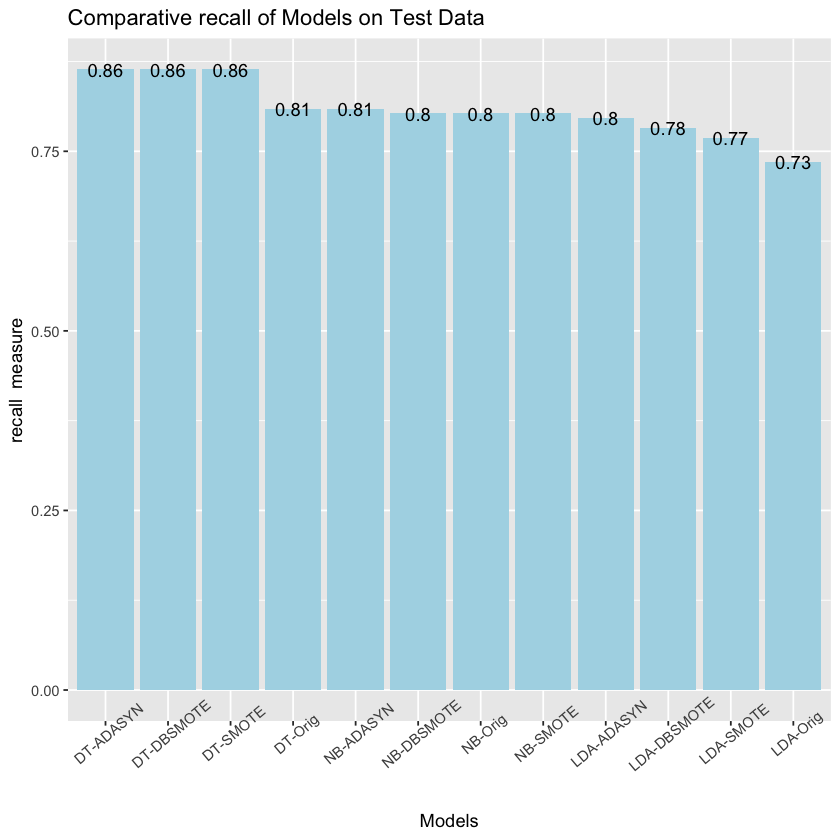

In [42]:
#Recall TP / TP + FN.
plot_metrics('recall', 'light blue')

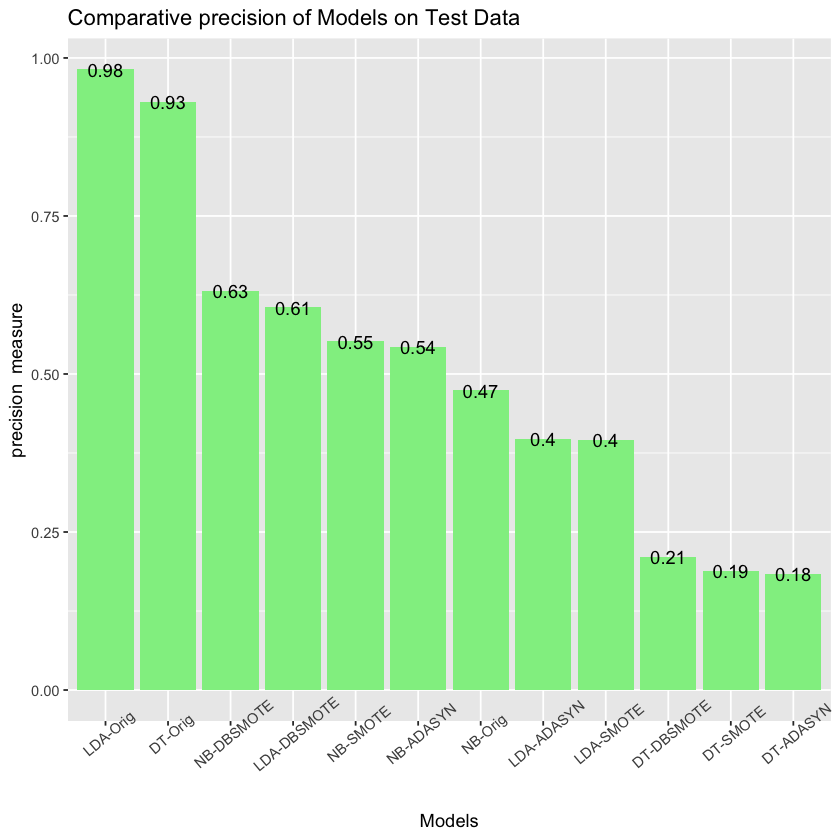

In [43]:
#Compare the Precision of the models: TP/TP+FP
plot_metrics('precision','light green')

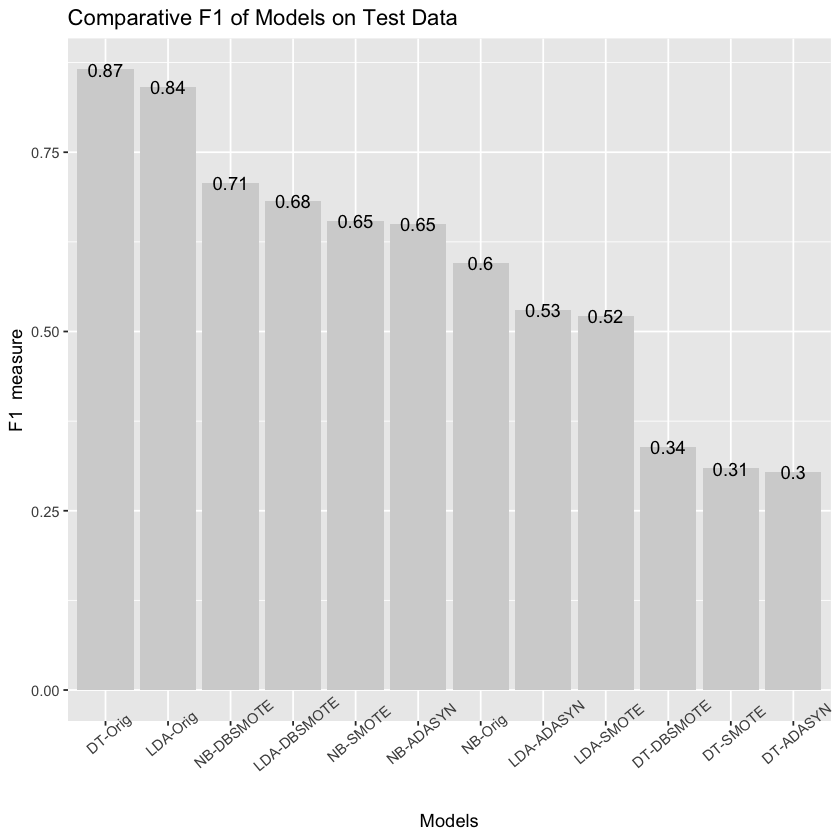

In [44]:
#Compare the F1 of the models: 2*((Precision*Recall) / (Precision + Recall))
plot_metrics('F1','light grey')